# 基于K-MEANS模型和RFM分类模型的订单交易用户价值分析

## Introduction

### 名词解释
`K-MEANS聚类` 是一种无监督学习的聚类方法,它根据样本之间的相似度将样本分成 K 个簇,每个样本只属于一个簇。

`RFM客户分类` 是根据客户的购买时间、购买频率和购买金额3个维度的趋势将客户分成不同细分层,每个客户可能属于多个层。

`二者区别`
- `K-MEANS聚类`是一种更广义的聚类方法,可以在任意数据集上进行聚类,但是结果的解释性较差。
- `RFM客户分类` 是一种针对客户数据的特定聚类方法,它只考虑 3 个重要特征,但是结果的可解释性很好,不同层代表的客户类型很清晰。

`适用场景`
- 如果目的是发掘数据集中的潜在客户分类,而不仅限于已有的`RFM客户分类`，`K-MEANS聚类`会更合适。
- 如果针对客户购买数据进行细分,并希望结果具有很强的解释性，`RFM客户分类`会更加实用。
- 也可以先使用`K-MEANS聚类`对全部客户进行初步分类，然后在每个簇内分别使用`RFM客户分类`进行进一步细分，这样可以充分利用两种方法的优点。

### 项目目的
本项目旨在使用数据挖掘技术对客户进行分类，以实现精准营销。具体目的如下：

- 使用`K-MEANS聚类`初步发现数据集中的大类客户群，为进一步客户细分提供参考。

- 在每个大类内使用`RFM客户分类`细分，发挥`RFM客户分类`在表达性强和结果易解释这两个方面的优势。因为在同一大类内,客户的属性相近,所以`RFM客户分类`细分结果也比较容易理解。

- 结合`K-MEANS聚类`和`RFM客户分类`两种方法的优势,进行全面而深入的客户分类，更好地了解客户需求和购买习惯，制定更针对性的营销策略，从而实现精准营销的目的。

## Import Libraries

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
# 忽略警告提示
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans

## Importing Data

In [2]:
# read data from CSV files
df_initial = pd.read_csv('./data/data.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})
data_df = df_initial.copy()

## Exploring Data Analysis(EDA)

### 查看数据信息

In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


### 查看缺失值

In [4]:
print(data_df.isna().mean()*100)
print(data_df.isna().sum())

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


### 查看重复值

In [5]:
print('重复的数据条目: {}'.format(data_df.duplicated().sum()))

重复的数据条目: 5268


### 查看异常值

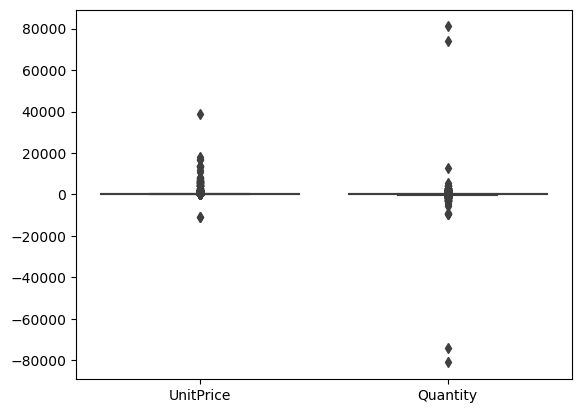

In [6]:
sns.boxplot(data=data_df[['UnitPrice','Quantity']])
plt.show()

## Data Cleaning

### 缺失值处理

CustomerID ~25%的数据记录为空的，这意味着有约25%的数据记录没有分配给任何客户。而我们目前没有数据可以将这些数据匹配到到任何客户。所以目前这些数据是没有用的，因此我们可以将其删除

In [7]:
data_df.dropna(axis = 0, subset = ['CustomerID'],inplace = True)

In [8]:
print(data_df.isna().sum())
print(data_df.shape)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64
(406829, 8)


### 重复值处理
>处理缺失值后，查看是否有重复值，有的话删除

In [9]:
data_df.drop_duplicates(inplace = True)

### 异常值处理

#### <=0的记录

In [10]:
Quantity_zero_count = len(data_df[data_df['Quantity'] == 0])
Quantity_nega_count = len(data_df[data_df['Quantity'] < 0])

print(f'Quantity=0的个数：{Quantity_zero_count}\nQuantity<0的个数：{Quantity_nega_count}')

Quantity=0的个数：0
Quantity<0的个数：8872


>quantity不存在0值。quantity负值与正数对称，应该是退款，暂不考虑退款，将quantity负数值直接删除。

In [11]:
data_df = data_df[data_df['Quantity'] > 0]

In [12]:
# 计算UnitPrice为0的数量
UnitPrice_zero_count = len(data_df[data_df['UnitPrice'] == 0])
print(f'UnitPrice是0的个数：{UnitPrice_zero_count}')

UnitPrice是0的个数：40


>UnitPrice不存在小于0的记录。等于 0 的记录，对模型没有影响，删除处理以减少数据复杂度。

In [13]:
data_df = data_df[data_df['UnitPrice'] > 0]

#### Country
>由于客户集群可能因地理位置而异，这里将数据限制为包含大多数客户数据的英国客户

In [14]:
data_df.Country.value_counts(normalize=True) 

Country
United Kingdom          0.889254
Germany                 0.022982
France                  0.021202
EIRE                    0.018401
Spain                   0.006313
Netherlands             0.006007
Belgium                 0.005172
Switzerland             0.004688
Portugal                0.003700
Australia               0.003007
Norway                  0.002727
Italy                   0.001930
Channel Islands         0.001902
Finland                 0.001744
Cyprus                  0.001536
Sweden                  0.001146
Austria                 0.001014
Denmark                 0.000968
Poland                  0.000840
Japan                   0.000817
Israel                  0.000624
Unspecified             0.000614
Singapore               0.000565
Iceland                 0.000463
USA                     0.000456
Canada                  0.000385
Greece                  0.000369
Malta                   0.000285
United Arab Emirates    0.000173
European Community      0.000153
RS

In [15]:
data_df = data_df[data_df.Country == 'United Kingdom']

### 数据类型
>将 "InvoiceDate" 列转换为日期格式,方便后续计算使用

In [16]:
data_df['InvoiceDate'] = pd.to_datetime(data_df['InvoiceDate'])

## RFM数据预处理

In [17]:
print(data_df.info())
print(len(data_df['CustomerID'].unique()))

<class 'pandas.core.frame.DataFrame'>
Index: 349203 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    349203 non-null  object        
 1   StockCode    349203 non-null  object        
 2   Description  349203 non-null  object        
 3   Quantity     349203 non-null  int64         
 4   InvoiceDate  349203 non-null  datetime64[ns]
 5   UnitPrice    349203 non-null  float64       
 6   CustomerID   349203 non-null  object        
 7   Country      349203 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 24.0+ MB
None
3920


### Recency
>计算每个客户最近一次距今的天数

In [18]:
inoviceDate_df = data_df.groupby('CustomerID')['InvoiceDate'].max().reset_index()

recency_df = pd.DataFrame(columns=['CustomerID', 'Recency'])
recency_df['CustomerID'] = inoviceDate_df['CustomerID']

# 实际业务中通常是根据当前日期计算
# today = pd.Timestamp(datetime.date.today())
# 因为本项目数据久远，以数据中最新日期的月底日期计算Recency
invoice_date = inoviceDate_df['InvoiceDate'].max()
latest_date = pd.Timestamp(year=invoice_date.year, month=invoice_date.month, day=pd.Period(invoice_date, freq='M').days_in_month)
# latest date - customer latest date = Recency
recency_df['Recency'] = (latest_date - inoviceDate_df['InvoiceDate']).dt.days

#### 查看Recency的分布

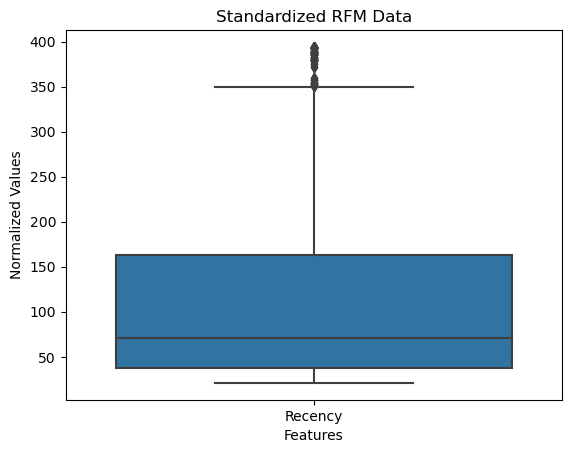

In [19]:
 # 创建箱线图
sns.boxplot(data=recency_df)

# 添加标题和坐标轴标签
plt.title('Standardized RFM Data')
plt.xlabel('Features')
plt.ylabel('Normalized Values')

# 显示图像
plt.show()

In [20]:
recency_df.describe()

,Recency
count,3920.000000
mean,112.742092
std,99.533485
min,21.000000
25%,38.000000
50%,71.000000
75%,163.000000
max,394.000000


#### 可视化

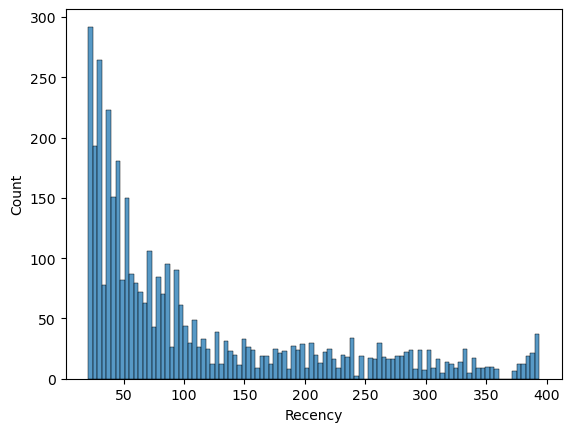

In [21]:
sns.histplot(data=recency_df, x='Recency', bins=100)
plt.show()

### Frequency
>统计数据时间内每个客户的订单数量作为Frequency

In [22]:
# 计算每个客户的频率
# 根据业务需求确认时间段（1month/3months/6months/1year），筛选客户的消费频率，因数据久远，用数据全时段的总消费次数作为消费频率
frequency_df = data_df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency_df.columns = ['CustomerID', 'Frequency']

#### 查看Frequency的分布

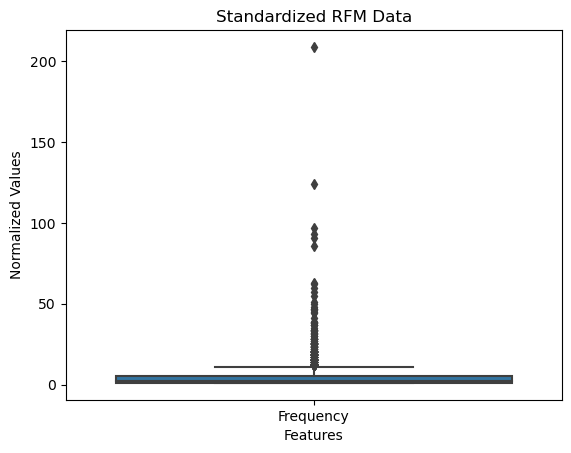

In [23]:
# 创建箱线图
sns.boxplot(data=frequency_df)

# 添加标题和坐标轴标签
plt.title('Standardized RFM Data')
plt.xlabel('Features')
plt.ylabel('Normalized Values')

# 显示图像
plt.show()

In [24]:
frequency_df.describe()

,Frequency
count,3920.000000
mean,4.246429
std,7.199202
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,209.000000


#### 可视化

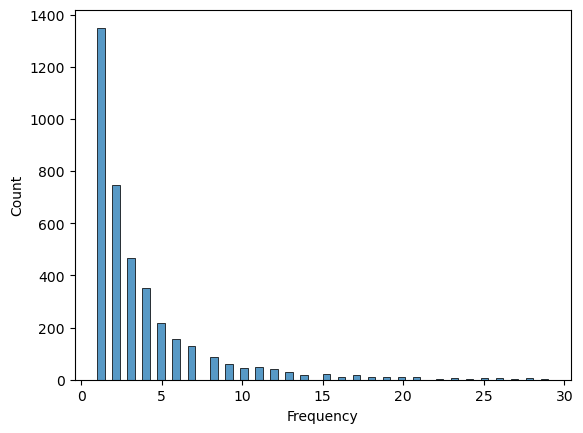

In [25]:
sns.histplot(data=frequency_df[frequency_df['Frequency']<30], x='Frequency', bins=60)
plt.show()

### Monetary
>统计数据时间内每个客户的总订单金额作为Monetary

In [26]:
# 计算每个客户的消费金额
# 同理，根据业务需求确认时间段（1month/3months/6months/1year），筛选客户的消费频率，次数用数据全时段的总消费金额作为Monetary
data_df['Monetary'] = data_df['Quantity'] * data_df['UnitPrice']
monetary_df = data_df.groupby('CustomerID')['Monetary'].sum().reset_index()
# 保留Monetary列的值到小数点后两位
monetary_df['Monetary'] = monetary_df['Monetary'].round(2)

#### 查看Monetary分布

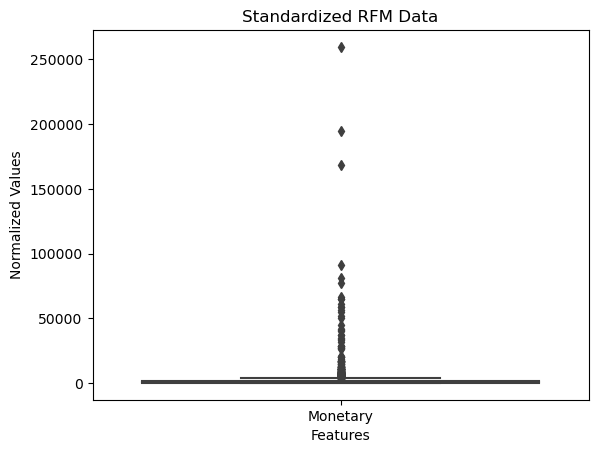

In [27]:
# 创建箱线图
sns.boxplot(data=monetary_df)
# 添加标题和坐标轴标签
plt.title('Standardized RFM Data')
plt.xlabel('Features')
plt.ylabel('Normalized Values')

# 显示图像
plt.show()

In [28]:
monetary_df.describe()

,Monetary
count,3920.000000
mean,1858.424653
std,7478.631256
min,3.750000
25%,298.185000
50%,644.975000
75%,1571.285000
max,259657.300000


#### 可视化

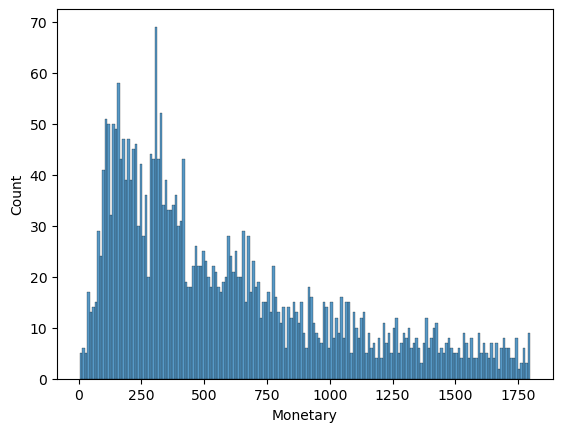

In [29]:
sns.histplot(data=monetary_df[monetary_df['Monetary']<1800], x='Monetary', bins=180)
plt.show()

### Customer RFM
>合并获取RFM的数据集

In [30]:
# 将三个 DataFrame 按照 CustomerID 列进行合并
rf_df = pd.merge(recency_df, frequency_df, on='CustomerID', how='inner')
seg_df = pd.merge(rf_df, monetary_df, on='CustomerID', how='inner')
ks_df = seg_df.copy()

### RFM指标相关性分析

#### 归一化处理

In [31]:
from sklearn.preprocessing import Normalizer

ks_normalized_df = ks_df.copy()
# 创建 Normalizer 对象
normalizer = Normalizer()

# 选取需要处理的列
col_names = ['Recency', 'Frequency','Monetary']
rfm_normalized = ks_df[col_names]

# 对选定列进行 L2 归一化处理
rfm_normalized_array = normalizer.fit_transform(ks_df[col_names])
ks_normalized_df[['Recency', 'Frequency','Monetary']] = pd.DataFrame(rfm_normalized_array)
# rfm_normalized.columns = col_names

In [32]:
ks_normalized_df.sample(10)
# rfm_normalized_df

,CustomerID,Recency,Frequency,Monetary
3361,17516,0.047013,0.006530,0.998873
3804,18129,0.919886,0.003484,0.392171
1978,15596,0.085707,0.003542,0.996314
2896,16849,0.856809,0.004139,0.515617
3664,17934,0.101706,0.002825,0.994811
2178,15860,0.063074,0.008272,0.997975
3861,18210,0.008392,0.002289,0.999962
2420,16200,0.023383,0.001871,0.999725
3622,17880,0.642709,0.001669,0.766109
1824,15385,0.189030,0.003099,0.981966


#### Person系数

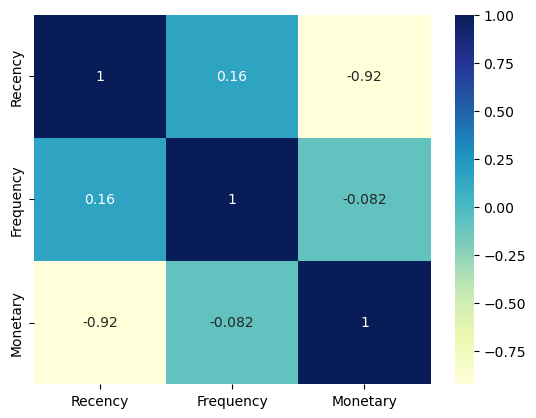

In [33]:
# 计算相关系数
corr_matrix = ks_normalized_df[['Recency', 'Frequency', 'Monetary']].corr()

# 可视化分析
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")

# 显示图表
plt.show()

>从图中可以看出 Recncy和Monetary的相关性最高，Recncy和Frequency的相关性次之，Frequency和Monetary的相关性最低。

## Kmeans Segment

对 R、F、M 分别进行K-means无监算法督分类，尝试对三者分类的结合进行解释。

### Exploring Best K

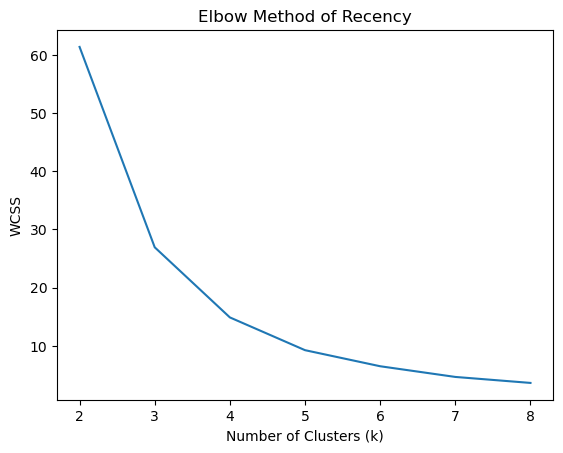

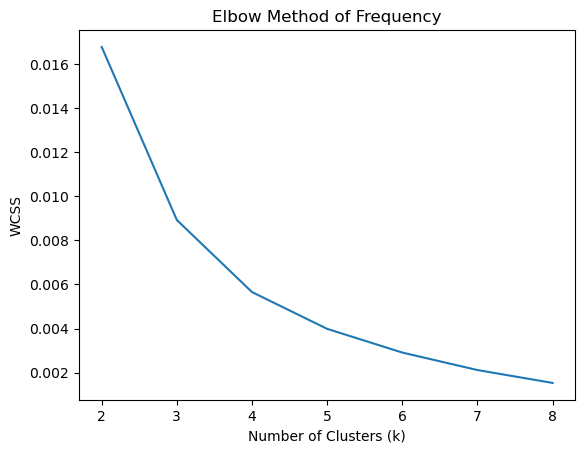

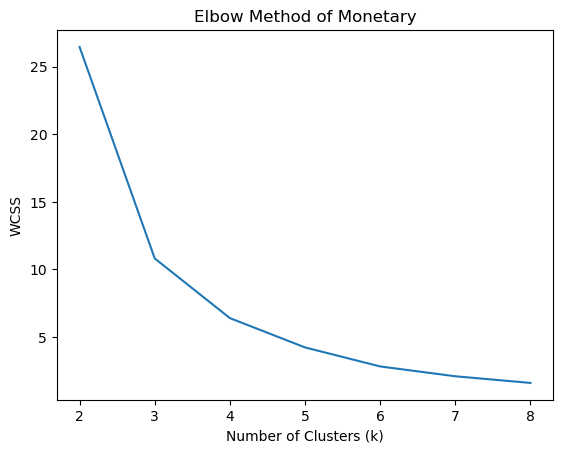

In [34]:
# Elbow Curve
selected_features = ['Recency','Frequency','Monetary']

for feature in selected_features:
    wcss = []
    for i in range(2,9):
        kmeans = KMeans(n_clusters=i, init='k-means++',random_state=0, max_iter=50)
        kmeans.fit(ks_normalized_df[[feature]])
        wcss.append(kmeans.inertia_)

    sns.lineplot(x=range(2, 9), y=wcss)
    plt.title(f'Elbow Method of {feature}')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS')
    plt.show()

根据Elbow Curve图，选取K=3。实际工作中，根据业务和解释性需求确认clusters数量

### Segment of R、F、M

In [35]:
for feature in selected_features:
    kmeans = KMeans(n_clusters=3,random_state=0)
    ks_df[feature+'-Cluster'] = kmeans.fit_predict(ks_df[[feature]])
    # ks_df[feature+'-Cluster'] = kmeans.labels_
    ks_normalized_df[feature+'-Cluster'] =  ks_df[feature+'-Cluster']

In [36]:
for feature in ['Recency','Frequency','Monetary']:
    print(f"{feature}的区间范围是[{ks_df[feature].min()},{ks_df[feature].max()}]")
    for cluster in range(3):
        min_n = ks_df[ks_df[feature+'-Cluster']==cluster][feature].min()
        max_n = ks_df[ks_df[feature+'-Cluster']==cluster][feature].max()
        text_ouput = f"{feature}的三个分类中，Cluster{cluster}区间范围是[{min_n},{max_n}]"
        print(text_ouput)
    print('='*(len(text_ouput)+10))

Recency的区间范围是[21,394]
Recency的三个分类中，Cluster0区间范围是[21,114]
Recency的三个分类中，Cluster1区间范围是[246,394]
Recency的三个分类中，Cluster2区间范围是[115,243]
Frequency的区间范围是[1,209]
Frequency的三个分类中，Cluster0区间范围是[1,12]
Frequency的三个分类中，Cluster1区间范围是[13,63]
Frequency的三个分类中，Cluster2区间范围是[86,209]
Monetary的区间范围是[3.75,259657.3]
Monetary的三个分类中，Cluster0区间范围是[3.75,21086.3]
Monetary的三个分类中，Cluster1区间范围是[168472.5,259657.3]
Monetary的三个分类中，Cluster2区间范围是[25977.16,91062.38]


根据RFM模型进行记分

In [37]:
# 将Cluster的值+1，方便后续分类
for feature in ['Recency-Cluster','Frequency-Cluster','Monetary-Cluster']:
    ks_df[feature] = ks_df[feature]+1

In [38]:
# 替换Monetary-Cluster中2和3的值，以匹配区间
ks_df['Monetary-Cluster'] = ks_df['Monetary-Cluster'].replace({2: 3, 3: 2})
ks_df['Recency-Cluster'] = ks_df['Recency-Cluster'].replace({1: 3, 3: 1})

In [39]:
# 合并['Recency-Cluster','Frequency-Cluster','Monetary-Cluster']三列的分类
ks_df['RFM'] = ks_df[['Recency-Cluster', 'Frequency-Cluster', 'Monetary-Cluster']].apply(lambda row: ''.join(map(str, row)), axis=1)
ks_df['RFM-Score'] = ks_df.apply(lambda row: row['Recency-Cluster'] + row['Frequency-Cluster'] + row['Monetary-Cluster'], axis=1)


### RFM客户分类

In [40]:
# 定义RFM模型的分类规则
code_pattern_list = ['333', '3*3', '*33', '**3', '33*', '3**', '*3*', '***']

# type_list = ['重要价值客户', '重要发展客户', '重要保持客户', '重要挽留客户',  
#              '一般价值客户', '一般发展客户', '一般保持客户', '一般挽留客户']

# type_list = ['Key valuable customer','Key develop customer',
#                 'Key retain customer','Key rescue customer',
#                 'General valuable customer','General develop customer',
#                 'General retain customer','General rescue customer']

type_list = ['K-valuable','K-develop','K-retain','K-rescue',
                'G-valuable','G-develop','G-retain','G-rescue']

customer_type_map = {} 
for pattern, ctype in zip(code_pattern_list, type_list):
    if pattern == '333':
        customer_type_map['333'] = ctype
    elif pattern == '3*3':
        customer_type_map['313'] = ctype
        customer_type_map['323'] = ctype
    elif pattern == '*33':
        customer_type_map['331'] = ctype 
        customer_type_map['332'] = ctype
    elif pattern == '**3':
        customer_type_map['311'] = ctype
        customer_type_map['312'] = ctype
    elif pattern == '33*':
        customer_type_map['331'] = ctype
        customer_type_map['332'] = ctype  
    elif pattern == '3**':
        customer_type_map['321'] = ctype
        customer_type_map['322'] = ctype
    elif pattern == '*3*':
        customer_type_map['311'] = ctype 
        customer_type_map['312'] = ctype
        customer_type_map['321'] = ctype
        customer_type_map['322'] = ctype
    else:
        customer_type_map['111'] = ctype
        customer_type_map['112'] = ctype
        customer_type_map['121'] = ctype
        customer_type_map['122'] = ctype
        customer_type_map['211'] = ctype
        customer_type_map['212'] = ctype
        customer_type_map['221'] = ctype
        customer_type_map['222'] = ctype
        
# print(customer_type_map) 
# 增加'客户分类'列
ks_df['Segment'] = ks_df['RFM'].map(customer_type_map)

In [41]:
ks_df.sample(10)

,CustomerID,Recency,Frequency,Monetary,Recency-Cluster,Frequency-Cluster,Monetary-Cluster,RFM,RFM-Score,Segment
1814,15370,61,7,2386.05,3,1,1,311,5,一般保持客户
109,12970,28,4,405.47,3,1,1,311,5,一般保持客户
956,14173,31,4,450.84,3,1,1,311,5,一般保持客户
2360,16121,78,2,854.66,3,1,1,311,5,一般保持客户
636,13716,290,1,138.28,2,1,1,211,4,一般挽留客户
2394,16164,38,3,822.48,3,1,1,311,5,一般保持客户
1206,14523,129,1,241.09,1,1,1,111,3,一般挽留客户
1072,14341,66,8,2166.98,3,1,1,311,5,一般保持客户
1847,15417,106,1,508.80,3,1,1,311,5,一般保持客户
2469,16265,30,9,5447.00,3,1,1,311,5,一般保持客户


### 分类可视化

In [42]:
segment_df = ks_df['Segment'].value_counts().to_frame().reset_index()
segment_df['%'] = round(segment_df['count']/ len(ks_df)*100,2)
segment_df

,Segment,count,%
0,一般保持客户,2630,67.09
1,一般挽留客户,1281,32.68
2,一般价值客户,6,0.15
3,重要发展客户,3,0.08


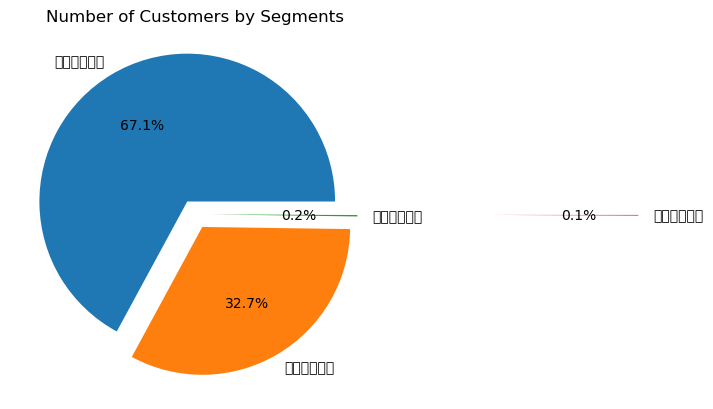

In [43]:
# 绘制Customers Segments的饼图
explode = (0.1, 0.1, 0.1, 2.0)
plt.pie(segment_df['count'], explode=explode, labels=segment_df['Segment'], autopct='%1.1f%%')
plt.title('Number of Customers by Segments')

plt.show()

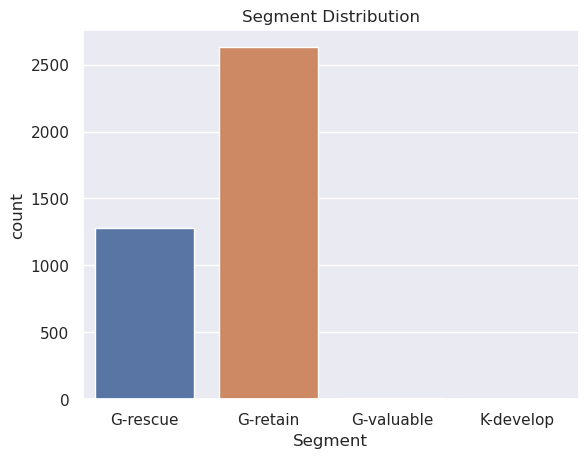

In [120]:
sns.set(style="darkgrid")  # 设置样式
# 假设 segment_df 是一个包含分段数据的DataFrame
sns.countplot(x='Segment', data=ks_df)
plt.title('Segment Distribution')  # 设置标题
plt.show()

## RFM Segment

### 确认分层标准

In [121]:
rfm_df = seg_df.copy()

In [122]:
rfm_df[['Recency','Frequency','Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,112.742092,4.246429,1858.424653
std,99.533485,7.199202,7478.631256
min,21.000000,1.000000,3.750000
25%,38.000000,1.000000,298.185000
50%,71.000000,2.000000,644.975000
75%,163.000000,5.000000,1571.285000
max,394.000000,209.000000,259657.300000


本项目以feature中位数为Segmentation标准，实际项目中以业务需求和实际数据分析为准

In [123]:
# 获取特征中位数
r_median = rfm_df['Recency'].median()
f_median = rfm_df['Frequency'].median()
m_median = rfm_df['Monetary'].median()

In [124]:
rfm_df['r_C'] = rfm_df['Recency'].apply(lambda x: 1 if x > r_median else 0)
rfm_df['f_C'] = rfm_df['Frequency'].apply(lambda x: 1 if x > f_median else 0) 
rfm_df['m_C'] = rfm_df['Monetary'].apply(lambda x: 1 if x > m_median else 0)

In [125]:
rfm_df['rfm_C'] = rfm_df[['r_C', 'f_C', 'm_C']].apply(lambda row: ''.join(map(str, row)), axis=1)
rfm_df

,CustomerID,Recency,Frequency,Monetary,r_C,f_C,m_C,rfm_C
0,12346,346,1,77183.60,1,0,1,101
1,12747,23,11,4196.01,0,1,1,011
2,12748,21,209,33053.19,0,1,1,011
3,12749,24,5,4090.88,0,1,1,011
4,12820,24,4,942.34,0,1,1,011
...,...,...,...,...,...,...,...,...
3915,18280,298,1,180.60,1,0,0,100
3916,18281,201,1,80.82,1,0,0,100
3917,18282,28,2,178.05,0,0,0,000
3918,18283,24,16,2045.53,0,1,1,011


### 分类情况

In [127]:
rfm_segment_df = rfm_df['rfm_C'].value_counts().to_frame().reset_index()
rfm_segment_df['%'] = round(rfm_segment_df['count']/ len(rfm_df)*100,2)
rfm_segment_df

,rfm_C,count,%
0,100,1195,30.48
1,011,1190,30.36
2,000,523,13.34
3,111,392,10.00
4,101,238,6.07
5,001,140,3.57
6,110,123,3.14
7,010,119,3.04


### 解释RFM分类

In [134]:
# rfm_map = {
#     '111': '重要价值客户',
#     '101': '重要发展客户', 
#     '011': '重要保持客户',
#     '001': '重要挽留客户',
#     '110': '一般价值客户',
#     '100': '一般发展客户',
#     '010': '一般保持客户',
#     '000': '一般挽留客户'
# }

rfm_map = {
    '111': 'K-valuable', 
    '101': 'K-develop',
    '011': 'K-retain',
    '001': 'K-rescue',
    '110': 'G-valuable', 
    '100': 'G-develop',
    '010': 'G-retain',
    '000': 'G-rescue'
}

In [135]:
# 增加'客户分类'列
rfm_df['Segment'] = rfm_df['rfm_C'].map(rfm_map)

In [136]:
rfm_df

,CustomerID,Recency,Frequency,Monetary,r_C,f_C,m_C,rfm_C,Segment
0,12346,346,1,77183.60,1,0,1,101,K-develop
1,12747,23,11,4196.01,0,1,1,011,K-retain
2,12748,21,209,33053.19,0,1,1,011,K-retain
3,12749,24,5,4090.88,0,1,1,011,K-retain
4,12820,24,4,942.34,0,1,1,011,K-retain
...,...,...,...,...,...,...,...,...,...
3915,18280,298,1,180.60,1,0,0,100,G-develop
3916,18281,201,1,80.82,1,0,0,100,G-develop
3917,18282,28,2,178.05,0,0,0,000,G-rescue
3918,18283,24,16,2045.53,0,1,1,011,K-retain


### 分类可视化

In [137]:
rfm_s_df = rfm_df['Segment'].value_counts().to_frame().reset_index()
rfm_s_df['%'] = round(rfm_s_df['count']/ len(ks_df)*100,2)
rfm_s_df

,Segment,count,%
0,G-develop,1195,30.48
1,K-retain,1190,30.36
2,G-rescue,523,13.34
3,K-valuable,392,10.00
4,K-develop,238,6.07
5,K-rescue,140,3.57
6,G-valuable,123,3.14
7,G-retain,119,3.04


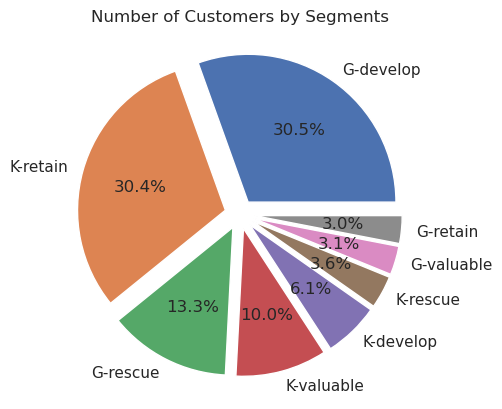

In [138]:
# 绘制Customers Segments的饼图
# len(rfm_s_df)
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1) 
plt.pie(rfm_s_df['count'], explode=explode, labels=rfm_s_df['Segment'], autopct='%1.1f%%')
plt.title('Number of Customers by Segments')

plt.show()

## 总结

科学的客户分类,可以更有效地进行针对性的营销,为运营提供有效的帮助,给决策层提供直观的数据支撑。

1. 重要价值客户:这类客户的价值高,是公司的重要客户,应该投入较多资源进行维系和开发。  
2. 重要发展客户:这类客户具有较高的潜在价值,是公司发展的重要客户,应加大开发力度,扩大业务规模。
3. 重要保持客户:这类客户当前的价值较高,是公司要重点保持的客户,要投入适度资源进行维护,确保客户关系稳定。
4. 重要挽留客户:这类客户的价值高,但是存在一定流失风险,是公司要重点挽留的客户,要投入较多资源进行维系,避免客户流失。
5. 一般价值客户:这类客户的当前价值一般,要适当投入资源进行维系。  
6. 一般发展客户:这类客户的潜在价值一般,要适度开发,逐步提高其价值。
7. 一般保持客户:这类客户的当前价值一般,要定期联系,维持良好的客户关系。
8. 一般挽留客户:这类客户存在一定的流失风险,要适度联系,减少流失概率。


- KMeans算法更加智能和客观,但需要高度的数据分析能力,并且结果也依赖于数据和模型设定。
- RFM模型简单直接,易于理解和应用,但存在一定主观性。

对于一些数据集不够复杂,且需要比较简单规则化的分类,RFM模型是一个不错的选择。对于数据集复杂,需要发现隐藏数据特征的情况,KMeans算法或更高级的机器学习模型会更加适用。也可以考虑将二者结合,使用KMeans获取客户簇,再为每个簇指定RFM代码,以达到更佳的效果。
总之,选择何种模型需要根据实际的业务场景和数据特征进行判断。理解各模型的优缺点,可以帮助我们做出更精准的选择。

## 参考文献

- [RFM model for customer purchase behavior using K-Means algorithm](https://www.sciencedirect.com/science/article/pii/S1319157819309802)
- [Exploring Customers Segmentation With RFM Analysis and K-Means Clustering](https://medium.com/web-mining-is688-spring-2021/exploring-customers-segmentation-with-rfm-analysis-and-k-means-clustering-118f9ffcd9f0)
- [RFM Customer Segmentation with K Means](https://rstudio-pubs-static.s3.amazonaws.com/671942_d7c20cc5f25d4fc2ac33c3556fc13e88.html)
- [Kaggle英国电商数据分析--k-means与RFM模型结合进行用户群体划分](https://blog.csdn.net/qq_45694768/article/details/121590772)
- [基于RFM和K-Means的用户分群](https://blog.csdn.net/ballhacker/article/details/107722255)
- [RFM模型及其用户运营实践](https://blog.csdn.net/yeonki/article/details/50573235)
- [客户价值分析【python建立RFM模型】](https://juejin.cn/post/7068946548066877447)
- [Customer-Segmentation-using-K-mean](https://github.com/jasneekchugh/Customer-Segmentation-using-K-mean/blob/main/K-means%20clustering%20using%20RFM%20variables.ipynb)